In [14]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset if k in all_features}
	return features

def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load training dataset (6K)
filename = r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# load test set
filename = r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_text\Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
#model-ep002-loss3.245-val_loss3.612.h5
filename = r'C:\Users\Owner\Documents\Spring 2018\Final\model_0.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.551927
BLEU-2: 0.280861
BLEU-3: 0.174941
BLEU-4: 0.069714


In [17]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# load training dataset (6K)
filename = r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_text\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [10]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
def extract_features(filename):
	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	image = load_img(filename, target_size=(224, 224))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)
	feature = model.predict(image, verbose=0)
	return feature
 
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34
filename = r'C:\Users\Owner\Documents\Spring 2018\Final\model_0.h5'
model = load_model(filename)
# load and prepare the photograph
photo_1 = extract_features(r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_1.jpg')
photo_2 = extract_features(r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_2.jpg')
photo_3 = extract_features(r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_3.jpg')
photo_4 = extract_features(r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_4.jpg')
# generate description
description_1 = generate_desc(model, tokenizer, photo_1, max_length)
description_2 = generate_desc(model, tokenizer, photo_2, max_length)
description_3 = generate_desc(model, tokenizer, photo_3, max_length)
description_4 = generate_desc(model, tokenizer, photo_4, max_length)

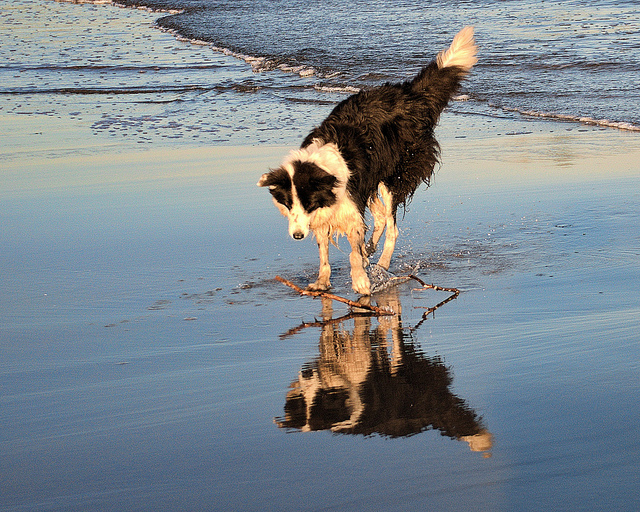

startseq dog is running through the water endseq


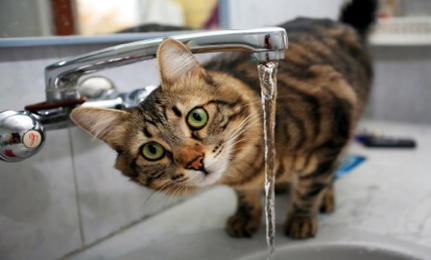

startseq two men are playing on the grass endseq


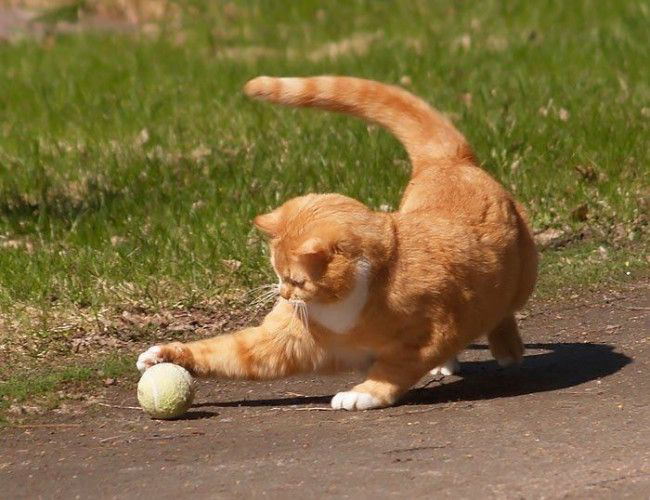

startseq dog is jumping in the grass endseq


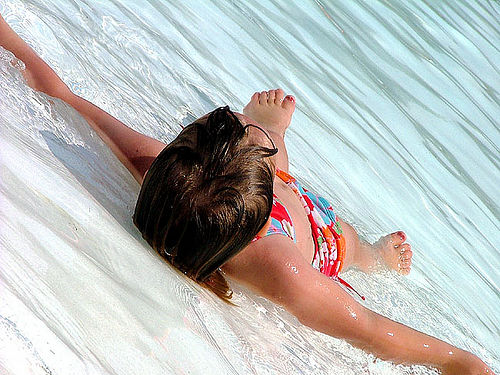

startseq two men are playing in the water endseq


In [12]:
from PIL import Image
path_1 = r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_1.jpg'  
display(Image.open(path_1))
print(description_1)

path_2 = r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_2.jpg'  
display(Image.open(path_2))
print(description_2)

path_3 = r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_3.jpg'  
display(Image.open(path_3))
print(description_3)

path_4 = r'C:\Users\Owner\Documents\Spring 2018\Final\Data_4\Flickr8k_Dataset\example_4.jpg'  
display(Image.open(path_4))
print(description_4)